
# **Подгружаем все необходимые библиотеки и функции**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add
from keras.layers.core import Activation

import numpy as np
from numpy import genfromtxt
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

import os
import sys
from PIL import Image
from skimage.io import imsave
from tqdm import tqdm

sys.path.insert(1, 'drive/My Drive/Rosneft Seismic/models/modules')

from dice_metric import dice_coef, dice_coef_loss, find_threshold
from uresnet_v3 import uresnet, unet, big_uresnet, Conv2D_34skipblock
from load_data import load_train, load_start_train, load_test
from load_data import cut_test_img, connect_test_img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Инициализируем константы**

In [0]:
K.set_image_data_format('channels_last')                # Формат последнего канала

LAYER = '0'                                             # Номер слоя земли
VERSION = 2                                             # Версия самбита
EPOCHS = 15                                             # Количество эпох обучения (чтобы укладывалось в 12 часов)
BATCH_SIZE = 4                                          # Размер батча обучения (максимально позволительное GPU)
VERBOSE = 1                                             # Подробности обучения
VALIDATION_SPLIT = 0.2                                  # Процент валидации от тренировочной выборки
OPTIMIZER = Adam()                                      # Оптимизатор 
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 384, 384, 1          # Размеры используемых моделью изображений
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
FILEPATH = 'drive/My Drive/Rosneft Seismic/models/weight/weights_layer_'+LAYER+'_v'+str(VERSION)+'.h5' # Путь к модели

# **Загружаем тренировочную выборку слоя LAYER**

In [5]:
x_train, y_train = load_train(LAYER)

  0%|          | 0/512 [00:00<?, ?it/s]

LOAD TRAIN DATA
--load inline images


  0%|          | 0/384 [00:00<?, ?it/s]

--end load inline images
--load xline images


  0%|          | 0/512 [00:00<?, ?it/s]

--end load xline images
--load turn inline images


  0%|          | 0/384 [00:00<?, ?it/s]

--end load turn inline images
--load turn xline images


  0%|          | 0/384 [00:00<?, ?it/s]

--end load turn xline images
--load noise xline images


  0%|          | 0/512 [00:00<?, ?it/s]

--end load noise xline images
--load sinus inline images


100%|██████████| 512/512 [07:13<00:00,  1.21it/s]


--end load sinus inline images
END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING


# **Запускаем обучение сети**
 **Строим график обучения**

In [6]:
model = big_uresnet(Conv2D_34skipblock, IMG_ROWS, IMG_COLS, IMG_CHANNELS)
#model = uresnet(Conv2D_34skipblock, IMG_ROWS, IMG_COLS, IMG_CHANNELS)
#model = unet(IMG_ROWS, IMG_COLS, IMG_CHANNELS)
model_checkpoint = ModelCheckpoint(filepath=FILEPATH, monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])


plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

















Train on 3072 samples, validate on 768 samples
Epoch 1/15
3072/3072 [==============================] - 1551s 505ms/step - loss: -0.9266 - dice_coef: 0.9266 - val_loss: -0.9567 - val_dice_coef: 0.9567
Epoch 2/15
3072/3072 [==============================] - 1527s 497ms/step - loss: -0.9893 - dice_coef: 0.9893 - val_loss: -0.9585 - val_dice_coef: 0.9585
Epoch 3/15
3072/3072 [==============================] - 1527s 497ms/step - loss: -0.9922 - dice_coef: 0.9922 - val_loss: -0.9583 - val_dice_coef: 0.9583
Epoch 4/15
 204/3072 [>.............................] - ETA: 21:48 - loss: -0.9924 - dice_coef: 0.9924

KeyboardInterrupt: ignored

## Дополнительные эпохи для дообучения


In [10]:
ADD_EPOCHS = 3

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=ADD_EPOCHS, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])


plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

Train on 3072 samples, validate on 768 samples
Epoch 1/3
3072/3072 [==============================] - 1540s 501ms/step - loss: -0.9923 - dice_coef: 0.9923 - val_loss: -0.9624 - val_dice_coef: 0.9624
Epoch 2/3
 628/3072 [=====>........................] - ETA: 18:37 - loss: -0.9931 - dice_coef: 0.9931

KeyboardInterrupt: ignored

# **Загружаем модель слоя LAYER**
 **Подбираем соответвующий treshold**


  2%|▏         | 10/512 [00:00<00:05, 97.12it/s]

LOAD TRAIN DATA
--load inline images


100%|██████████| 512/512 [00:05<00:00, 88.56it/s]


--end load inline images
--load xline images
NONE
--end load xline images
END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING
512/512 [==============================] - 67s 132ms/step


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


0.22


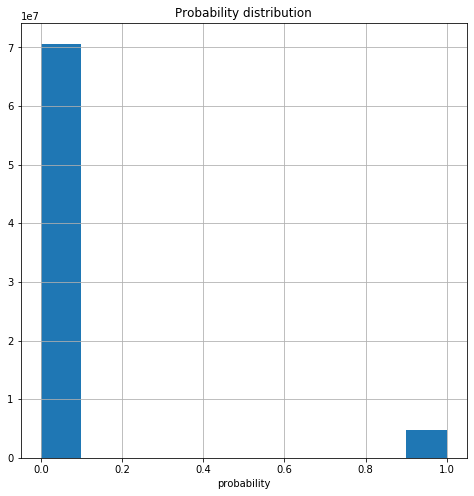

In [7]:
model = load_model(FILEPATH, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

x_start, y_start = load_start_train(LAYER)
y_pred = model.predict(x_start, verbose=1)

plt.figure(figsize=(8, 8))
plt.hist(y_pred.flatten())
plt.title('Probability distribution')
plt.xlabel('probability')
plt.grid()
plt.show()

threshold = find_threshold(y_start, y_pred)
print(threshold)

# **Загружаем тестовую выборку слоя LAYER**

In [8]:
test_name, x_test = load_test()

100%|██████████| 2751/2751 [13:35<00:00,  3.89it/s]


# **Запускаем модель на тестовой выборке**

In [9]:
test_path = 'drive/My Drive/Rosneft Seismic/test/answer/' + LAYER + '/'
for name, image in tqdm(zip(test_name, x_test)):
  image = list(image)
  size, cut_image = cut_test_img(image)

  predict = model.predict(cut_image, verbose=0)

  y_test = connect_test_img(size, predict)
  y_test = np.where(y_test < threshold, 0, 255)
  y_test = y_test.astype(np.uint8)

  imsave(test_path+name, y_test)


1871it [23:14,  1.87it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1873it [23:15,  1.97it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3593.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1875it [23:16,  2.06it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1879it [23:18,  1.97it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3591.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1880it [23:18,  2.15it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.p